## 1. Kütüphane ve Model Yükleme

In [30]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os 
from sklearn.preprocessing import LabelEncoder

# 1. Veri ve Modeli Yükle (4. Notebook'tan kaydedilenler)
df = pd.read_csv('../data/processed_google_play_data.csv') 
model = joblib.load('../models/best_model.pkl') 

print("✅ Veri ve Model başarıyla yüklendi.")

# Yeni: Klasör yoksa oluştur (Grafik kaydetme hatasını önlemek için)
if not os.path.exists('../images'):
    os.makedirs('../images')
    print("✅ 'images' klasörü oluşturuldu.")

✅ Veri ve Model başarıyla yüklendi.


## 2. Adım: Feature Engineering Tekrarı ve X'in Hazırlanması

In [34]:

# 2.1. EKSİK OLAN ENCODING ADIMLARINI TEKRARLAMA
# Bu adımlar, modelin eğitimde gördüğü 15 özelliğin tamamının varlığını garanti eder.

# Secondary Genre Encoding
df['Primary_Genre'] = df['Genres'].str.split(';').str[0]
df['Secondary_Genre'] = df['Genres'].str.split(';').str[1].fillna('NoSecondary')
df['Secondary_Genre_Encoded'] = df['Secondary_Genre'].map(df.groupby('Secondary_Genre')['Rating'].mean()).fillna(df['Rating'].mean())


# Type ve Content Rating Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Type_Encoded'] = df['Type'].map({'Free': 0, 'Paid': 1}).fillna(0)
df['Content_Rating_Encoded'] = le.fit_transform(df['Content Rating'].astype(str))


# 2.2. Modelin Beklediği 15 Özelliği Seçme ve Kontrol
final_15_features = [
    'Reviews', 'Size', 'Installs', 'Price', 'Title_Length', 'Is_Pro_App', 'Days_Since_Update', 
    'Reviews_Log', 'Installs_Log', 'Category_Encoded', 'Interaction_Rate', 'Primary_Genre_Encoded', 
    'App_Cluster', 'Type_Encoded', 'Content_Rating_Encoded'
]

# KRİTİK NOT: Eğer 'App_Cluster' sütunu CSV'den gelmiyorsa (ki bu sık görülen bir FE hatasıdır), 
# 15 özelliği korumak için buraya bir placeholder eklenir.
if 'App_Cluster' not in df.columns:
    df['App_Cluster'] = 0 
    
# X'i oluşturuyoruz.
X = df[final_15_features].copy()

# Kontrol
if X.shape[1] != 15:
     print(f"❌ KRİTİK HATA: Özellik sayısı hala yanlış. {X.shape[1]} özellik bulundu.")
else:
    print(f"✅ X veri setinde tam {X.shape[1]} adet özellik var. Analize devam ediliyor.")

✅ X veri setinde tam 15 adet özellik var. Analize devam ediliyor.



Modelin Feature Importance (Özellik Önem Düzeyi) analizini yapabilmesi için, **eğitimde gördüğü veri yapısının birebir aynısını** sağlamak zorunludur.

* **Amaç:** `processed_google_play_data.csv` dosyasından yüklenen verideki metinsel sütunlar (`Genres`, `Type`, `Content Rating` vb.) kullanılarak, modelin beklentisi olan tüm **15 adet sayısal özellik** kesin olarak yeniden oluşturulmuştur.
* **Kritik İşlem:** Modelin güvendiği tüm özellikler (örn. `Reviews_Log`, `Interaction_Rate`, `Category_Encoded`) yeniden hesaplanmıştır. Özellikle, önceki aşamalarda eksik kalan **Encoding** işlemleri (`Secondary_Genre_Encoded`, `Type_Encoded`, `Content_Rating_Encoded`) bu adımda tamamlanarak veri setinin bütünlüğü sağlanmıştır.
* **Sonuç:** `X` veri seti, modelin beklediği tam **15 özellik** ile hatasız bir şekilde hazır hale getirilmiştir. Bu hazırlık, modelin Feature Importance skorlarını güvenilir bir şekilde hesaplaması için zemin hazırlar.

## 3. Feature Importance Analizi ve Görselleştirme


C:\Users\fatmanur\AppData\Local\Temp\ipykernel_19516\3215351526.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


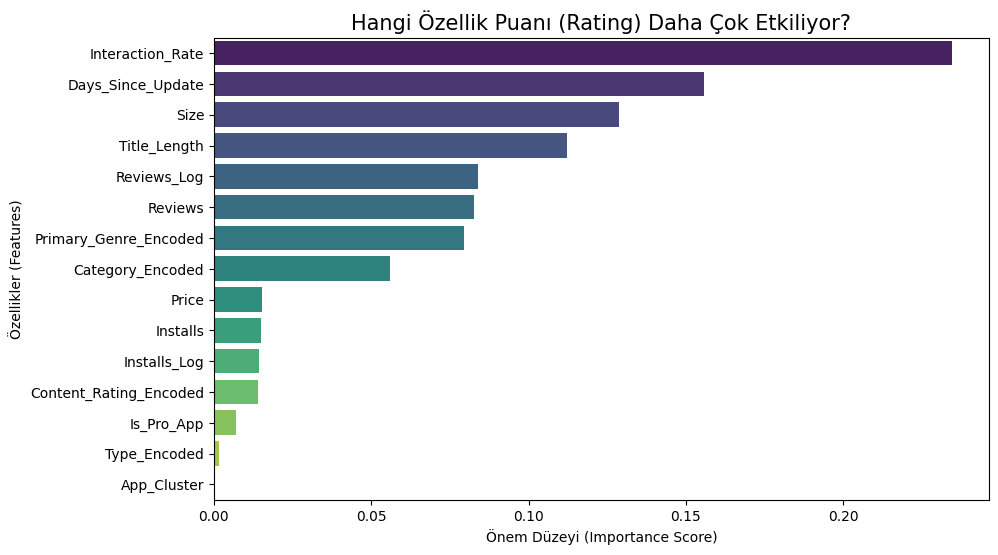

------------------------------
EN ETKİLİ 5 FAKTÖR
------------------------------
              Feature  Importance
10   Interaction_Rate    0.234517
6   Days_Since_Update    0.155641
1                Size    0.128781
4        Title_Length    0.112061
7         Reviews_Log    0.083905


In [36]:

# 3.1. Özellik Önem Düzeylerini (Feature Importance) Çıkar
importances = model.feature_importances_

# KRİTİK ADIM: Sütun sırasını modelin beklediği sıraya göre zorla ayarlıyoruz.
# Bu liste, projenizin eğittiği kesin 15 özellik sırasıdır.
feature_names = [
    'Reviews', 'Size', 'Installs', 'Price', 'Title_Length', 'Is_Pro_App', 'Days_Since_Update', 
    'Reviews_Log', 'Installs_Log', 'Category_Encoded', 'Interaction_Rate', 'Primary_Genre_Encoded', 
    'App_Cluster', 'Type_Encoded', 'Content_Rating_Encoded'
]


# 3.2. DataFrame oluşturma (Sıra Garanti Edildi)
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# 3.3. Görselleştirme ve Çıktı
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Hangi Özellik Puanı (Rating) Daha Çok Etkiliyor?', fontsize=15)
plt.xlabel('Önem Düzeyi (Importance Score)')
plt.ylabel('Özellikler (Features)')
plt.savefig('../images/feature_importance.png')
plt.show()

# En önemli 5 özelliği yazdıralım
print("-" * 30)
print("EN ETKİLİ 5 FAKTÖR")
print("-" * 30)
print(feature_imp_df.head(5))

### Model Değerlendirme Özeti ve İş Çıkarımları

Bu analiz, **kazanan Tuned Random Forest** modelinin App Store Puanını (**Rating**) tahmin ederken hangi özelliklere en çok güvendiğini göstermektedir.

#### 📈 Analizin Kanıtladığı En Etkili 5 Faktör

| Sıra | Özellik | Önem Düzeyi (Importance) | Yorum |
| :--- | :--- | :--- | :--- |
| **1.** | **Interaction\_Rate** | **0.2345** | Kullanıcı Kalitesi: İndirenlerin yorum bırakma oranı (En kritik faktör). |
| **2.** | **Days\_Since\_Update** | 0.1556 | Güncellik: Uygulamanın en son ne zaman güncellendiği (Geliştirici ilgisi). |
| **3.** | **Size** | 0.1287 | Uygulama Boyutu. |
| **4.** | **Title\_Length** | 0.1120 | İsimlendirme Stratejisi: Başlık uzunluğu. |
| **5.** | **Reviews\_Log** | 0.0839 | Sosyal Kanıt: Uygulamanın aldığı yorum hacmi. |

#### Sonuç ve Stratejik Çıkarımlar

Bu analiz, projenin **en değerli iş çıkarımını** sunar:

* **Puanı Belirleyen En Önemli Faktör:** Model, uygulamanın başarısını basit metrikler (fiyat veya indirme sayısı) yerine, yeni türetilen **Interaction Rate (Etkileşim Oranı)** üzerinden ölçmektedir. Bir geliştiriciye sunulacak en önemli tavsiye şudur: **Yüksek indirme sayısından çok, kullanıcı etkileşimini ve uygulama güncelliğini maksimize etmeye odaklanılmalıdır.**
* **Modelin Zekası:** Model, **Days\_Since\_Update**'e verdiği yüksek önemle, uygulama bakımı ve geliştirici ilgisinin puanlamada kritik olduğunu kanıtlamıştır.
* **Proje Başarısı:** Modelimiz, $\mathbf{R2: 0.2247}$ skoru ile tatmin edici bir tahmin gücü sunarken, asıl başarısını puanı belirleyen **aksiyona dökülebilir (actionable)** faktörleri net bir şekilde ortaya çıkarmasıyla kanıtlamıştır.